<a href="https://colab.research.google.com/github/stepanjaburek/quantum_social_science_lr/blob/main/stepan_colab_pca_cluster_3.1.25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data wrangling

#Setup

In [5]:
!pip install scikit-learn-extra
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from IPython.display import display

data = pd.read_csv("/content/0_kw_analysis.csv")
metadata = pd.read_excel("/content/pdf_list(1).xlsx")



#Data cleaning

In [6]:
# Rename "Broekaert_2018" in metadata
metadata.loc[252, 'file_name'] = "Broekaert_2018_The Tacit 'Quantum' of Meeting the Aesthetic Sign; Contextualize, Entangle,2.pdf"
data.loc[252, 'filename'] = "Broekaert_2018_The Tacit 'Quantum' of Meeting the Aesthetic Sign; Contextualize, Entangle,2.pdf"
# Delete duplicit paper "Yukalov et al. - 2018 - Information processing by networks of quantum deci.pdf"
data = data.drop(1170)
# Delete paper "Yilmaz - 2017 - Quantum cognition models of ethical decision-makin.pdf" that is only present in data
data = data.drop(1166)
# Delete paper "Park_2016_Decision-making &amp quantum mechanical models of cognitive processing.pdf" that is only present in metadata
metadata = metadata.drop(892)

# Keywords

In [7]:
# Exclude authors and create df
df = data.drop(columns=[data.columns[i] for i in [1,2,4,16,30]])
# Exclude social science fields
df = df.drop(columns=df.columns[26:38])
# Possibly also Exclude "quantum" and "quantization"
df = df.drop(columns=df.columns[17:19])

# keep only papers with some non-zero values in the final columns we want to keep
df = df[df.iloc[:, 2:24].sum(axis=1) > 0]
df = df.reset_index(drop=True)

In [8]:
[(i, list(df.keys())[i]) for i in range(len(df.keys()))]

[(0, 'filename'),
 (1, "born's rule"),
 (2, 'collapse'),
 (3, 'commutativity'),
 (4, 'complementarity'),
 (5, 'contextuality'),
 (6, 'eigenvalue'),
 (7, 'eigenvector'),
 (8, 'entanglement'),
 (9, 'exclusion principle'),
 (10, 'hamiltonian'),
 (11, 'hilbert space'),
 (12, 'interference'),
 (13, 'measurement problem'),
 (14, 'observer effect'),
 (15, 'operator'),
 (16, 'probability amplitude'),
 (17, 'dinger equation'),
 (18, 'superposition'),
 (19, 'tunneling'),
 (20, 'uncertainty'),
 (21, 'uncertainty principle'),
 (22, 'wave function'),
 (23, 'wave-particle duality')]

In [ ]:
# Or keeep only the authors
#df = data[data.columns[[1,2,4,16,30]]]

# Numbering the data for centroid extraction

In [9]:
metadata = metadata.reset_index()
metadata = metadata.rename(columns={'index': 'id'})
metadata['id'] = metadata['id'] + 1

df = df.reset_index()
df = df.rename(columns={'index': 'id'})
df['id'] = df['id'] + 1

# Scaling in the rows

In [10]:
# create features for the pca
features = df.drop(['filename', 'id'], axis=1)
feature_names = features.columns


features = features.div(features.sum(axis=1), axis=0) # row normalization as Michael suggested, dividing the values by the sum of their row (paper)
#features = StandardScaler().fit_transform(features.T).T # Z-score standardization on transposed data to work in rows

features = pd.DataFrame(features, columns=feature_names)
features

,born's rule,collapse,commutativity,complementarity,contextuality,eigenvalue,eigenvector,entanglement,exclusion principle,hamiltonian,...,observer effect,operator,probability amplitude,dinger equation,superposition,tunneling,uncertainty,uncertainty principle,wave function,wave-particle duality
0,0.0,0.000000,0.014218,0.014218,0.000000,0.071090,0.056872,0.009479,0.0,0.023697,...,0.0,0.492891,0.000000,0.014218,0.018957,0.0,0.047393,0.009479,0.000000,0.0
1,0.0,0.046729,0.000000,0.000000,0.000000,0.084112,0.000000,0.009346,0.0,0.336449,...,0.0,0.327103,0.009346,0.037383,0.018692,0.0,0.056075,0.018692,0.018692,0.0
2,0.0,0.028571,0.000000,0.000000,0.550000,0.007143,0.000000,0.071429,0.0,0.007143,...,0.0,0.042857,0.000000,0.000000,0.028571,0.0,0.014286,0.000000,0.035714,0.0
3,0.0,0.000000,0.000000,0.000000,0.829787,0.000000,0.000000,0.021277,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.063830,0.000000,0.000000,0.0
4,0.0,0.073171,0.024390,0.012195,0.243902,0.012195,0.048780,0.000000,0.0,0.036585,...,0.0,0.036585,0.000000,0.000000,0.073171,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,0.0,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.852941,0.0,0.000000,...,0.0,0.088235,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1156,0.0,0.000000,0.000000,0.000000,0.000000,0.075000,0.000000,0.875000,0.0,0.000000,...,0.0,0.050000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
1157,0.0,0.097826,0.000000,0.000000,0.032609,0.000000,0.000000,0.043478,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.054348,0.0,0.423913,0.086957,0.206522,0.0
1158,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.400000,0.0,0.000000,0.000000,0.000000,0.0


# Scaling in the columns

In [ ]:
# create features for the pca
features = df.drop(['filename', 'id'], axis=1)
feature_names = features.columns

# scale with either z-score standardization or MinMax normalization
# features = StandardScaler().fit_transform(features) #Z-score
# features = MinMaxScaler().fit_transform(features) # MinMax

#features.iloc[:, 1:23] = (features.iloc[:, 1:23] > 0).astype(int) # binary >0
#features.iloc[:, 1:23] = (features.iloc[:, 1:23] > 4).astype(int) # binary >4

features = pd.DataFrame(features, columns=feature_names)
features

# Data analysis

#PCA

Explained variance ratio: [0.2180545  0.17694912 0.12283425 0.10140376 0.07855793]


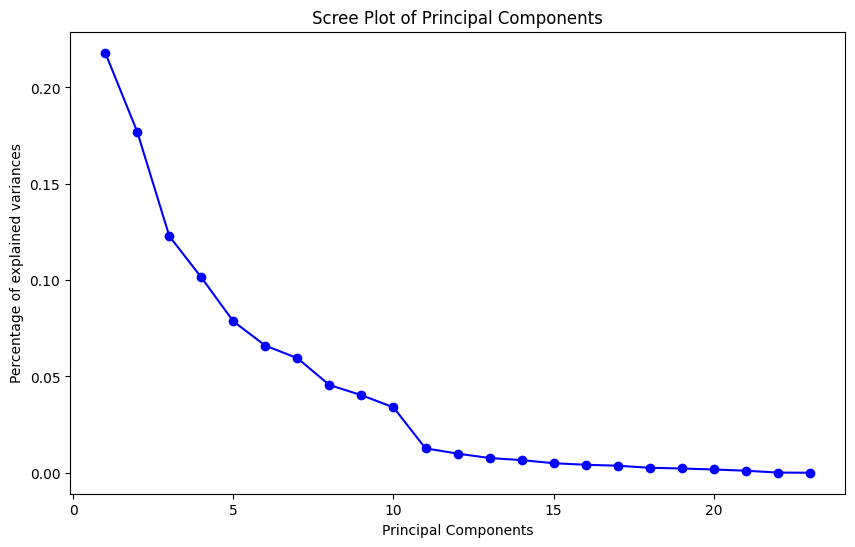

                                 feature    PC   loading
entanglement                entanglement   PC1  0.825301
operator                        operator   PC1 -0.535973
uncertainty                  uncertainty   PC1 -0.091734
hamiltonian                  hamiltonian   PC1 -0.080616
interference                interference   PC1 -0.074837
...                                  ...   ...       ...
complementarity          complementarity  PC23  0.208514
exclusion principle  exclusion principle  PC23  0.208514
collapse                        collapse  PC23  0.208514
interference                interference  PC23  0.208514
operator                        operator  PC23  0.208514

[115 rows x 3 columns]
                     feature   PC   loading
entanglement    entanglement  PC1  0.825301
interference    interference  PC1 -0.074837
hamiltonian      hamiltonian  PC1 -0.080616
uncertainty      uncertainty  PC1 -0.091734
operator            operator  PC1 -0.535973
operator            operator

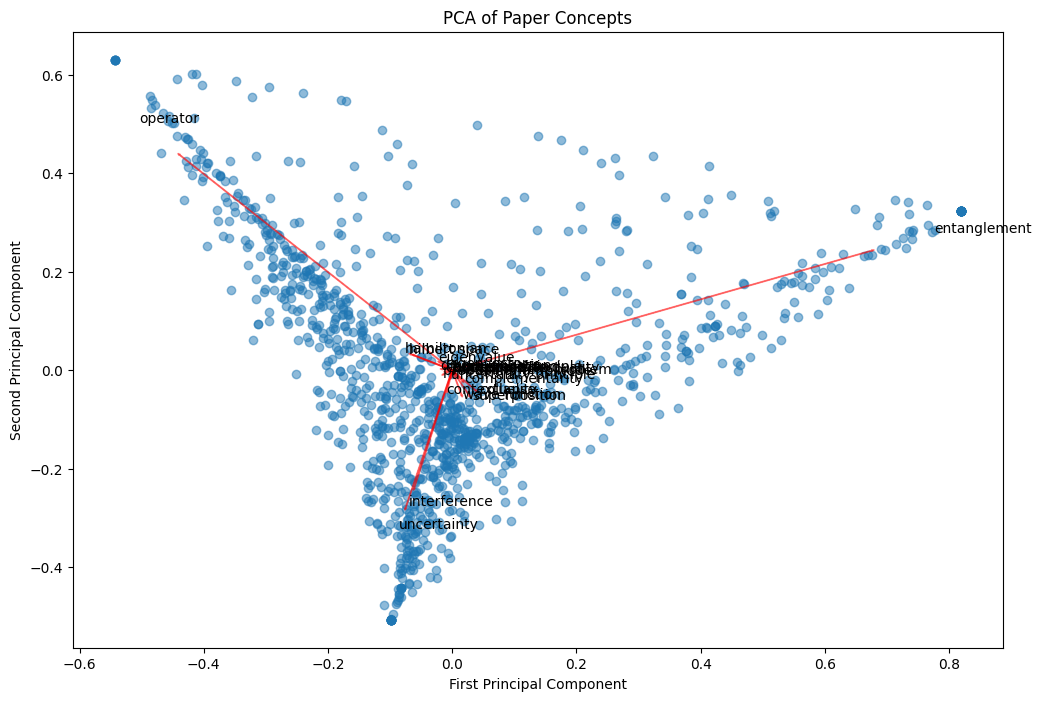

,feature,PC,loading
entanglement,entanglement,PC1,0.825301
interference,interference,PC1,-0.074837
hamiltonian,hamiltonian,PC1,-0.080616
uncertainty,uncertainty,PC1,-0.091734
operator,operator,PC1,-0.535973
operator,operator,PC2,0.693171
entanglement,entanglement,PC2,0.384904
superposition,superposition,PC2,-0.081875
interference,interference,PC2,-0.380279
uncertainty,uncertainty,PC2,-0.444384


In [11]:
pca = PCA()
pca_result = pca.fit_transform(features)
print("Explained variance ratio:", pca.explained_variance_ratio_[:5])

# Scree plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, 'bo-')
plt.title('Scree Plot of Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Percentage of explained variances')
plt.show()

# Feature importance in components
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(len(pca.components_))],
    index=features.columns
)

# Top 5 features per component
top_loadings = pd.DataFrame()
for pc in loadings.columns:
    top_5 = pd.DataFrame({
        'feature': loadings.index,
        'PC': pc,
        'loading': loadings[pc]
    })

    top_5 = top_5.reindex(top_5['loading'].abs().sort_values(ascending=False).index)
    top_5 = top_5.head(5)
    top_loadings = pd.concat([top_loadings, top_5])

print(top_loadings)

# PC1 and 2
pc12_loadings = top_loadings[top_loadings['PC'].isin(['PC1', 'PC2', 'PC3', 'PC4'])]
pc12_loadings = pc12_loadings.sort_values(['PC', 'loading'],
                                         ascending=[True, False])
print(pc12_loadings)

# PCA biplot
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)

for i, feature in enumerate(features.columns):
    plt.arrow(0, 0,
              pca.components_[0, i]*max(abs(pca_result[:, 0])),
              pca.components_[1, i]*max(abs(pca_result[:, 1])),
              color='r', alpha=0.5)
    plt.text(pca.components_[0, i]*max(abs(pca_result[:, 0]))*1.15,
             pca.components_[1, i]*max(abs(pca_result[:, 1]))*1.15,
             feature)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Paper Concepts')
plt.show()
display(pc12_loadings)

# K-means cluster analysis

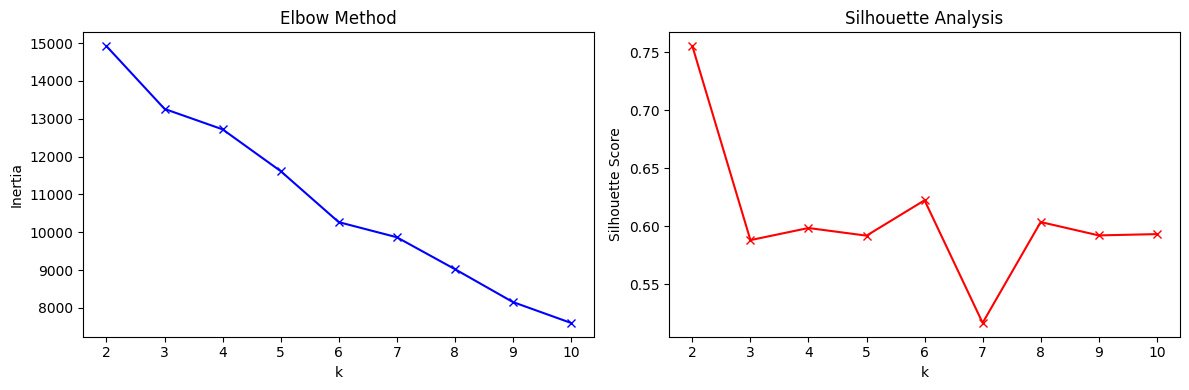

In [ ]:
from sklearn.metrics import silhouette_score

def optimize_kmeans(data, max_clusters=10):
    silhouette_scores = []
    inertias = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))
        inertias.append(kmeans.inertia_)

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(range(2, max_clusters + 1), inertias, 'bx-')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Elbow Method')

    ax2.plot(range(2, max_clusters + 1), silhouette_scores, 'rx-')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')

    plt.tight_layout()
    plt.show()

    return silhouette_scores, inertias

scores, inertias = optimize_kmeans(pca_result[:, :5]) # number of dimensions taken into account while clustering

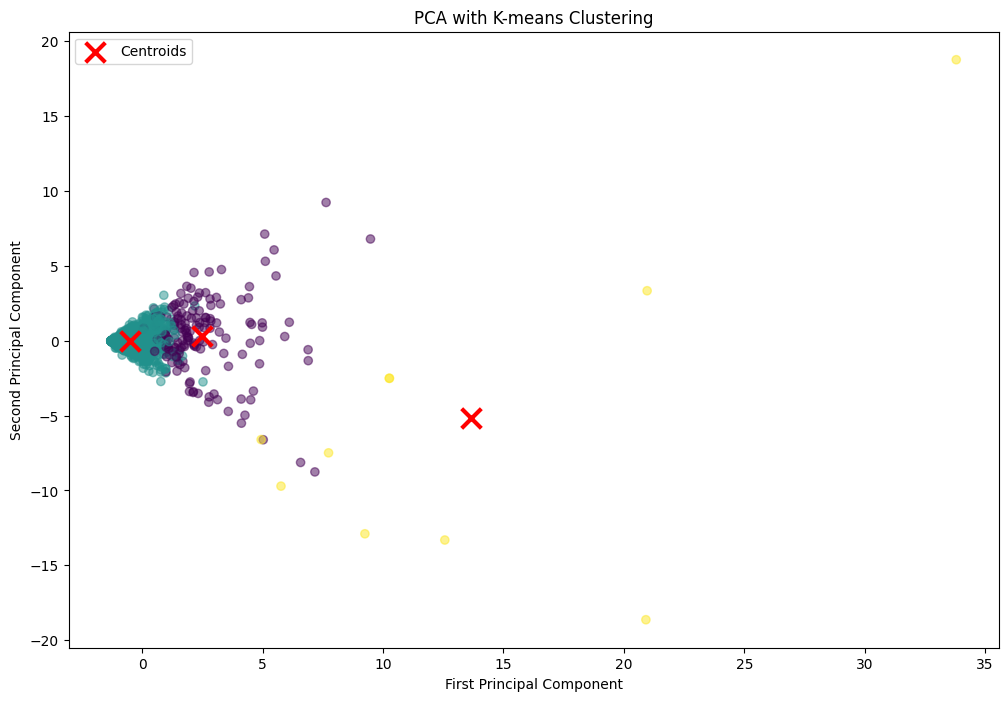

In [ ]:
# Key parameters to alter
######################
n_clusters = 3 # number of clusters
kmeans = KMeans(n_clusters=n_clusters,
                random_state=42)
cluster_labels = kmeans.fit_predict(pca_result[:, :5]) # number of dimensions in the analysis

# Get the centroids
centroid_coords = kmeans.cluster_centers_

# Function to get top papers for each centroid
def get_top_papers(centroid_coord, pca_data, df, cluster_num, n_top=10): # number of central papers to extarct
    distances = np.sum((pca_data - centroid_coord)**2, axis=1)
    top_indices = np.argsort(distances)[:n_top]
    return pd.DataFrame({
        'cluster': [cluster_num + 1] * n_top,
        'rank': range(1, n_top + 1),
        'centroid_id': df['id'].iloc[top_indices].values,
        'distance': distances[top_indices]
    })

# Get top papers for each centroid
centroids_list = []
for i in range(n_clusters):
    cluster_papers = get_top_papers(centroid_coords[i], pca_result[:, :5], df, i) # here as well number of dimensions in the analysis
    centroids_list.append(cluster_papers)

centroids = pd.concat(centroids_list, ignore_index=True)

centerpapers = pd.merge(centroids, metadata, left_on='centroid_id', right_on='id', how='left')
centerpapers.to_csv('center_papers_means.csv', index=False)

# Viz
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
           c='red', marker='x', s=200, linewidths=3, label='Centroids')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA with K-means Clustering')
plt.legend()
plt.show()

# K-medoids cluster analysis

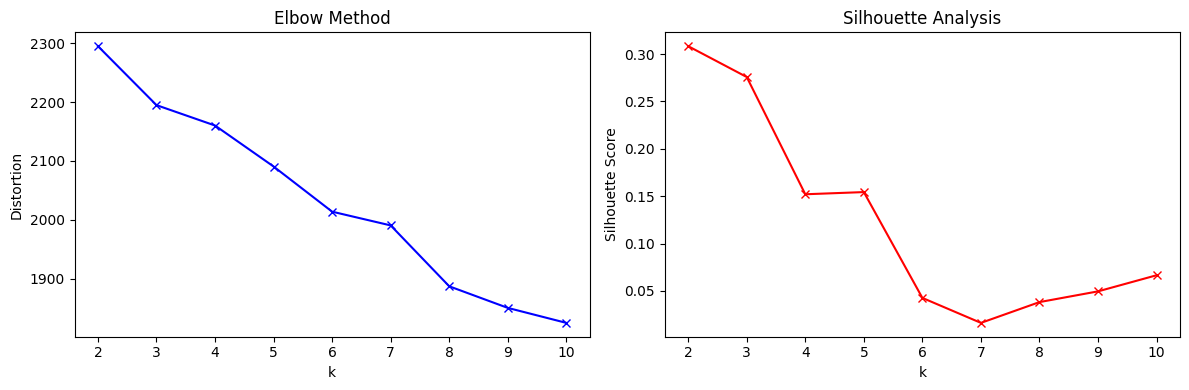

In [ ]:
def find_optimal_clusters(data, max_clusters=10):
    silhouette_scores = []
    distortions = []

    for k in range(2, max_clusters + 1):
        pam = KMedoids(n_clusters=k,
                       random_state=42,
                       metric='euclidean',
                       method='alternate')
        labels = pam.fit_predict(data)
        silhouette_avg = silhouette_score(data, labels)
        silhouette_scores.append(silhouette_avg)
        distortions.append(pam.inertia_)

    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Elbow plot
    ax1.plot(range(2, max_clusters + 1), distortions, 'bx-')
    ax1.set_xlabel('k')
    ax1.set_ylabel('Distortion')
    ax1.set_title('Elbow Method')

    # Silhouette plot
    ax2.plot(range(2, max_clusters + 1), silhouette_scores, 'rx-')
    ax2.set_xlabel('k')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Analysis')

    plt.tight_layout()
    plt.show()

    return silhouette_scores, distortions
scores, distortions = find_optimal_clusters(pca_result[:, :5]) # number of dimensions taken into account while clustering

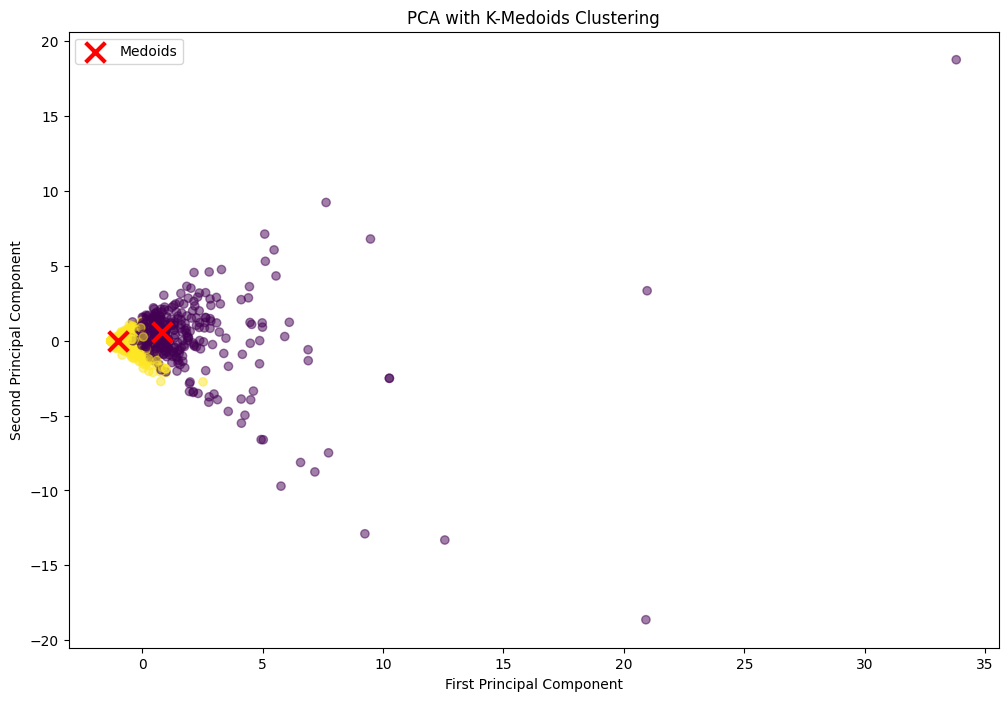

In [ ]:
# Key parameters to alter
######################
n_clusters = 2 # number of clusters
pam = KMedoids(n_clusters=n_clusters,
               random_state=42,
               metric='euclidean',
               method='alternate')
cluster_labels = pam.fit_predict(pca_result[:, :5]) # number of dimensions in the analysis

# Get the medoid coordinates
medoid_indices = pam.medoid_indices_
medoid_coords = pca_result[medoid_indices, :5] # here as well number of dimensions in the analysis

# Function to get top papers for each centroid
def get_top_papers(centroid_coord, pca_data, df, n_top=10): # number of central papers to extarct
    distances = np.sum((pca_data - centroid_coord)**2, axis=1)
    top_indices = np.argsort(distances)[:n_top]
    return pd.DataFrame({
        'cluster': [pam.medoid_indices_.tolist().index(medoid_indices[i]) + 1] * n_top,
        'rank': range(1, n_top + 1),
        'centroid_id': df['id'].iloc[top_indices].values,
        'distance': distances[top_indices]
    })

# Get top papers for each centroid
centroids_list = []
for i, medoid_coord in enumerate(medoid_coords):
    cluster_papers = get_top_papers(medoid_coord, pca_result[:, :5], df)
    centroids_list.append(cluster_papers)

centroids = pd.concat(centroids_list, ignore_index=True)

centerpapers = pd.merge(centroids, metadata, left_on='centroid_id', right_on='id', how='left')
centerpapers.to_csv('center_papers_medoids.csv', index=False)

# Viz
plt.figure(figsize=(12, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
plt.scatter(pca_result[medoid_indices, 0], pca_result[medoid_indices, 1],
           c='red', marker='x', s=200, linewidths=3, label='Medoids')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA with K-Medoids Clustering')
plt.legend()
plt.show()

# Overlap of clusters
only limited use for now, but this should be extendable to anything else

In [ ]:
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

# Z-Score K-means

In [ ]:
n_clusters = 3
dims = [2, 3, 4, 5, 10]
z3means2, z3means3,z3means4, z3means5, z3means10 = [
    KMeans(n_clusters=n_clusters, random_state=42).fit_predict(pca_result[:, :d])
    for d in dims
]

In [ ]:
import numpy as np

labels_dict = {
    '2 dims': z3means2,
    '3 dims': z3means3,
    '4 dims': z3means4,
    '5 dims': z3means5,
    '10 dims': z3means10
}

n = len(labels_dict)
ari_matrix = pd.DataFrame(np.zeros((n, n)),
                         columns=labels_dict.keys(),
                         index=labels_dict.keys())

for i in labels_dict.keys():
    for j in labels_dict.keys():
        ari = adjusted_rand_score(labels_dict[i], labels_dict[j])
        ari_matrix.loc[i,j] = round(ari, 3)

print("Adjusted Rand Index Scores between different dimensionalities:")
print(ari_matrix)

Adjusted Rand Index Scores between different dimensionalities:
         2 dims  3 dims  4 dims  5 dims  10 dims
2 dims    1.000   0.804   0.908   0.784    0.776
3 dims    0.804   1.000   0.849   0.648    0.687
4 dims    0.908   0.849   1.000   0.749    0.748
5 dims    0.784   0.648   0.749   1.000    0.828
10 dims   0.776   0.687   0.748   0.828    1.000


# MinMax K-Means

In [ ]:
n_clusters = 3
dims = [2, 3, 4, 5, 10]
m3means2, m3means3,m3means4, m3means5, m3means10 = [
    KMeans(n_clusters=n_clusters, random_state=42).fit_predict(pca_result[:, :d])
    for d in dims
]

In [ ]:
import numpy as np

labels_dict = {
    '2 dims': m3means2,
    '3 dims': m3means3,
    '4 dims': m3means4,
    '5 dims': m3means5,
    '10 dims': m3means10
}

n = len(labels_dict)
ari_matrix = pd.DataFrame(np.zeros((n, n)),
                         columns=labels_dict.keys(),
                         index=labels_dict.keys())

for i in labels_dict.keys():
    for j in labels_dict.keys():
        ari = adjusted_rand_score(labels_dict[i], labels_dict[j])
        ari_matrix.loc[i,j] = round(ari, 3)

print("Adjusted Rand Index Scores between different dimensionalities:")
print(ari_matrix)

Adjusted Rand Index Scores between different dimensionalities:
         2 dims  3 dims  4 dims  5 dims  10 dims
2 dims    1.000   0.538   0.759   0.798    0.777
3 dims    0.538   1.000   0.684   0.581    0.678
4 dims    0.759   0.684   1.000   0.842    0.968
5 dims    0.798   0.581   0.842   1.000    0.844
10 dims   0.777   0.678   0.968   0.844    1.000


In [ ]:
from IPython.display import display
display(ari_matrix)

,2 dims,3 dims,4 dims,5 dims,10 dims
2 dims,1.000,0.398,0.856,0.146,0.106
3 dims,0.398,1.000,0.498,0.038,0.027
4 dims,0.856,0.498,1.000,0.111,0.080
5 dims,0.146,0.038,0.111,1.000,0.826
10 dims,0.106,0.027,0.080,0.826,1.000


# Z-score K-Medoids

In [ ]:
n_clusters = 2
dims = [2, 3, 4, 5, 10]
z3medoids2, z3medoids3, z3medoids4, z3medoids5, z3medoids10 = [
    KMedoids(n_clusters=n_clusters, random_state=42, metric='euclidean',
             method='alternate').fit_predict(pca_result[:, :d])
    for d in dims
]

In [ ]:
import numpy as np

labels_dict = {
    '2 dims': z3medoids2,
    '3 dims': z3medoids3,
    '4 dims': z3medoids4,
    '5 dims': z3medoids5,
    '10 dims': z3medoids10
}

n = len(labels_dict)
ari_matrix = pd.DataFrame(np.zeros((n, n)),
                         columns=labels_dict.keys(),
                         index=labels_dict.keys())

for i in labels_dict.keys():
    for j in labels_dict.keys():
        ari = adjusted_rand_score(labels_dict[i], labels_dict[j])
        ari_matrix.loc[i,j] = round(ari, 3)

print("Adjusted Rand Index Scores between different dimensionalities:")
print(ari_matrix)

Adjusted Rand Index Scores between different dimensionalities:
         2 dims  3 dims  4 dims  5 dims  10 dims
2 dims    1.000   0.463   0.730   0.632    0.354
3 dims    0.463   1.000   0.458   0.388    0.469
4 dims    0.730   0.458   1.000   0.554    0.369
5 dims    0.632   0.388   0.554   1.000    0.372
10 dims   0.354   0.469   0.369   0.372    1.000


In [ ]:
from IPython.display import display
display(ari_matrix)

,2 dims,3 dims,4 dims,5 dims,10 dims
2 dims,1.000,0.463,0.730,0.632,0.354
3 dims,0.463,1.000,0.458,0.388,0.469
4 dims,0.730,0.458,1.000,0.554,0.369
5 dims,0.632,0.388,0.554,1.000,0.372
10 dims,0.354,0.469,0.369,0.372,1.000


# Comparing Z-scores, MinMax, Binary




In [ ]:
# Compare each dimensionality pair
comparisons = {
   '2 dims': adjusted_rand_score(z3means2, b3means2),
   '3 dims': adjusted_rand_score(z3means3, b3means3),
   '4 dims': adjusted_rand_score(z3means4, b3means4),
   '5 dims': adjusted_rand_score(z3means5, b3means5),
   '10 dims': adjusted_rand_score(z3means10, b3means10)
}

# Create DataFrame
comparison_df = pd.DataFrame.from_dict(comparisons, orient='index', columns=['ARI Score'])
print("KMeans vs KMedoids comparison at different dimensions:")
print(comparison_df)

KMeans vs KMedoids comparison at different dimensions:
         ARI Score
2 dims    0.017464
3 dims    0.003694
4 dims    0.007661
5 dims    0.026209
10 dims   0.089356


In [ ]:
# Compare each dimensionality pair
comparisons = {
   '2 dims': adjusted_rand_score(m3means2, b3means2),
   '3 dims': adjusted_rand_score(m3means3, b3means3),
   '4 dims': adjusted_rand_score(m3means4, b3means4),
   '5 dims': adjusted_rand_score(m3means5, b3means5),
   '10 dims': adjusted_rand_score(m3means10, b3means10)
}

# Create DataFrame
comparison_df = pd.DataFrame.from_dict(comparisons, orient='index', columns=['ARI Score'])
print("KMeans vs KMedoids comparison at different dimensions:")
print(comparison_df)

KMeans vs KMedoids comparison at different dimensions:
         ARI Score
2 dims    0.040789
3 dims    0.006966
4 dims    0.017969
5 dims    0.028403
10 dims   0.066180


In [ ]:
# Compare each dimensionality pair
comparisons = {
   '2 dims': adjusted_rand_score(m3means2, z3means2),
   '3 dims': adjusted_rand_score(m3means3, z3means3),
   '4 dims': adjusted_rand_score(m3means4, z3means4),
   '5 dims': adjusted_rand_score(m3means5, z3means5),
   '10 dims': adjusted_rand_score(m3means10, z3means10)
}

# Create DataFrame
comparison_df = pd.DataFrame.from_dict(comparisons, orient='index', columns=['ARI Score'])
print("KMeans vs KMedoids comparison at different dimensions:")
print(comparison_df)

KMeans vs KMedoids comparison at different dimensions:
         ARI Score
2 dims    0.599007
3 dims    0.610429
4 dims    0.621733
5 dims    0.719408
10 dims   0.680496


In [ ]:
display(comparison_df)

,ARI Score
2 dims,0.599007
3 dims,0.610429
4 dims,0.621733
5 dims,0.719408
10 dims,0.680496
